# MadMiner tutorial 1: From cards to likelihood ratios (parton level)

Johann Brehmer, Felix Kling, Kyle Cranmer 2018

In this tutorial we'll introduce the basic MadMiner workflow, using parton-level samples with simple smearing functions. We'll show you how to use MadMiner to generate events, extract training data, and train neural networks to estimate likelihood ratios.

This tutorial does not try to explain the inference methods. To understand what MadMiner is doing, please have a look at some papers first. In
["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013)
we explain the basic idea of most of the methods presented here, while ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020) is an extensive 65-page handbook going through the details.

## Preparations

Before you execute this notebook, make sure you have running installations of MadGraph, Pythia, and Delphes.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.core import MadMiner
from madminer.lhe import LHEReader
from madminer.sampling import combine_and_shuffle
from madminer.sampling import SampleAugmenter
from madminer import sampling
from madminer.ml import ParameterizedRatioEstimator
from madminer.plotting import plot_2d_morphing_basis, plot_distributions
from madminer.limits import AsymptoticLimits


Please enter here the path to your MG5 root directory.

In [2]:
mg_dir = '/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2'

MadMiner uses the Python `logging` module to provide additional information and debugging output. You can choose how much of this output you want to see by switching the level in the following lines to `logging.DEBUG` or `logging.WARNING`.

In [3]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.DEBUG
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## Input data

As an example process, we'll simulate VBF Higgs production with a decay into two photons. We'll try to measure two EFT coefficients that affect this process.

Have a look at the `cards` folder. You'll find text files ("cards") that specify the process simulation in typical MadGraph convention.

## 1. Define parameter space

After creating a `MadMiner` instance, the first important step is the definition of the parameter space. Each model parameter is characterized by a name as well as the LHA block and ID.

If morphing is used, one also has to specify the maximal power with which the parameter contributes to the squared matrix element. For instance, a parameter that contributes only to one vertex, will typically have `morphing_max_power=2`, while a parameter that contributes to two vertices usually has `morphing_max_power=4`. Exceptions arise for instance when the interference effects between the SM and dimension-six operators are modelled, but the square of the dimension-six amplitude (subleading in 1/Lambda) is not taken into account, in which case `morphing_max_power=1`. The `parameter_range` argument defines the range of parameter values that are used for the automatic optimization of the morphing basis.

Finally, the parameter values theta used internally by MadMiner and the parameter values written to the param_card (or reweight_card) given to MadGraph do not have to be exactly the same. With the option `parm_card_transform`, the user can supply a one-parameter function that maps a parameter value theta to the value given to MadGraph. This string is a python expression, in which `theta` is parsed as the parameter value. For instance, if the internal parameters are in the range (0, 1), but should be linearly scaled to (0, 100) in the param_card, one would have to use `param_card_transform="100*theta"`.

In [ ]:
miner = MadMiner()

miner.add_parameter(
    lha_block='dim6',
    lha_id=2,
    parameter_name='CWL2',
    morphing_max_power=2,
    param_card_transform="16.52*theta",
    parameter_range=(-10.,10.)
)
miner.add_parameter(
    lha_block='dim6',
    lha_id=5,
    parameter_name='CPWL2',
    morphing_max_power=2,
    param_card_transform="16.52*theta",
    parameter_range=(-10.,1.0)
)

## 2. Define benchmark points (evaluation points for |M|^2)

The next step is the definition of all the points at which the weights (squared matrix elements) should be evaluated by MadGraph. We call these points "benchmarks".

### Set benchmarks by hand

One can define benchmarks by hand:

In [ ]:
miner.add_benchmark(
    {'CWL2':0., 'CPWL2':0.},
    'sm'
)
miner.add_benchmark(
    {'CWL2':10., 'CPWL2':0.},
    'w'
)

### Morphing setup

If morphing is used, the function `set_morphing` has to be called. With the option `include_existing_benchmarks=True`, MadMiner will keep all the benchmark points defined beforehand and run a simple optimization algorithm to fix the remaining ones for the basis (which may be none). Otherwise, MadMiner will optimize the full basis and forget about all previously defined benchmark points.

The other important keyword is `max_overall_power`. This sets the maximal combined power with which all parameters together contribute to the squared matrix element (cross section). This constraint is in addition to the `morphing_max_power` keyword of `add_parameter()` (see above). For instance, if there are two parameters of interest `a` and `b`, and it is known that there are contributions proportional to `1` (constant), `a`, `a^2`, `b`, `b^2`, and `ab`, then `max_overall_power=2`. If there are also contributions proportional to `a^2 b`, `a b^2`, and `a^2 b^2`, then `max_overall_power=4`.

In [ ]:
miner.set_morphing(
    include_existing_benchmarks=True,
    max_overall_power=2
)

Let's have a look at the resulting morphing basis and the "morphing error", i.e. the sum of squared morphing weights as a function of the parameter space. The black dots mark the benchmarks at which the squared matrix element will be evaluated when MadGraph is run. In between them, the morphing will interpolate. Since the morphing knows about the functional form of the amplitudes, there is only a small numerical uncertainty in this interpolation, we expect that the color in this plot is indicative of this uncertainty.

In [ ]:
fig = plot_2d_morphing_basis(
    miner.morpher,
    xlabel=r'$c_{W} v^2 / \Lambda^2$',
    ylabel=r'$c_{\tilde{W}} v^2 / \Lambda^2$',
    xrange=(-10.,10.),
    yrange=(-10.,10.)
)

The parameter space, benchmark points, and morphing setup are saved in a HDF5 file:

In [ ]:
miner.save('data/madminer_example.h5')

They can now be loaded again with `miner.load(filename)`.

## 3. Save settings and run MadGraph

In a next step, MadMiner starts MadGraph to generate events and calculate the weights. You have to provide paths to the process card, run card, param card (the entries corresponding to the parameters of interest will be automatically adapted), and an empty reweight card. Log files in the `log_directory` folder collect the MadGraph output and are important for debugging.

The `sample_benchmark` option can be used to specify which benchmark should be used for sampling. If it is not used, MadMiner will automatically use the benchmark that was added first.

Finally, if your default Python interpreter is 3.x, you will want to use `python2_override=True` to force MadGraph to be started with Python 2.x.

In [ ]:
miner.run(
    sample_benchmark='sm',
    mg_directory=mg_dir,
    mg_process_directory='./mg_processes/signal',
    proc_card_file='cards/proc_card_signal.dat',
    param_card_template_file='cards/param_card_template.dat',
    run_card_file='cards/run_card_signal.dat',
    log_directory='logs/signal',
    python2_override=True,
)

This will take a moment -- time for a coffee break!

After running any event generation through MadMiner, you should check whether the run succeeded: are the usual output files there (LHE and HepMC), do the log files show any error messages? MadMiner does not perform any explicit checks, and if something went wrong in the event generation, it will only notice later when trying to load the event files.

It is possible to start multiple processes based on the same `MadMiner` instance. This can be used to combine samples sampled according to different benchmarks, and to add reducible backgrounds. 

For the latter, a useful option is the `is_background` switch, which should be used for processes that do *not* depend on the parameters theta. `is_background=True` will disable the reweighting and re-use the same weights for all cross sections.

To reduce the runtime of the notebook, the background part is commented out here. Feel free to activate it and let it run during a lunch break.

In [ ]:
"""
miner.run(
    is_background=True,
    sample_benchmark='sm',
    mg_directory=mg_dir,
    mg_process_directory='./mg_processes/background',
    proc_card_file='cards/proc_card_background.dat',
    param_card_template_file='cards/param_card_template.dat',
    run_card_file='cards/run_card_background.dat',
    log_directory='logs/background',
)
"""

Finally, two options might be very useful for larger projects:
- `MadMiner.run_multiple()` allows you to start multiple runs with different run cards or different choices of `sample_benchmark`.
- Both `MadMiner.run()` and `MadMiner.run_multiple()` have a `only_create_script` keyword. If that is set to True, MadMiner will not start the event generation directly, but prepare folders with all the right settings and ready-to-run bash scripts. This might make it much easier to generate Events on a high-performance computing system. 

## 4. Run smearing and extract observables

The `madminer.lhe` submodule allows us to extract observables directly from the parton-level LHE samples, including an approximate description of the detector response with smearing functions. The central object is an instance of the `LHEProcessor` class, which has to be initialized with a MadMiner file:

In [ ]:
lhe = LHEReader('data/madminer_example.h5')

After creating the LHEProcessor object, one can add a number of event samples (the output of running MadGraph in step 3) with the `add_sample()` function.

In addition, you have to provide the information which sample was generated from which benchmark with the `sampled_from_benchmark` keyword, and set `is_background=True` for all background samples.

In [ ]:
lhe.add_sample(
    lhe_filename='mg_processes/signal/Events/run_01/unweighted_events.lhe.gz',
    sampled_from_benchmark='sm',
    is_background=False,
    k_factor=1.1,
)

"""
lhe.add_sample(
    lhe_filename='mg_processes/background/Events/run_01/unweighted_events.lhe.gz',
    sampled_from_benchmark='sm',
    is_background=True,
    k_factor=1.0,
"""


Now we have to define the smearing functions that are used (in lieu of a proper shower and detector simulation). Here we will assume a simple 10% uncertainty on the jet energy measurements and a $\pm 0.1$ smearing for jet $\eta$ and $\phi$. The transverse momenta of the jets are then derived from the smeared energy and the on-shell condition for the quarks (this is what `pt_resolution_abs=None` does). The photons from the Higgs are assumed to be measured perfectly (otherwise we'd have to call `set_smearing` another time with `pdgis=[22]`).

In [ ]:
lhe.set_smearing(
    pdgids=[1,2,3,4,5,6,9,22,-1,-2,-3,-4,-5,-6],   # Partons giving rise to jets
    energy_resolution_abs=0.,
    energy_resolution_rel=0.1,
    pt_resolution_abs=None,
    pt_resolution_rel=None,
    eta_resolution_abs=0.1,
    eta_resolution_rel=0.,
    phi_resolution_abs=0.1,
    phi_resolution_rel=0.,
)

The next step is the definition of observables, either through a Python function or an expression that can be evaluated. Here we demonstrate the latter, which is implemented in `add_observable()`. In the expression string, you can use the terms `j[i]`, `e[i]`, `mu[i]`, `a[i]`, `met`, where the indices `i` refer to a ordering by the transverse momentum. In addition, you can use `p[i]`, which denotes the `i`-th particle in the order given in the LHE sample (which is the order in which the final-state particles where defined in MadGraph).

All of these represent objects inheriting from scikit-hep [LorentzVectors](http://scikit-hep.org/api/math.html#vector-classes), see the link for a documentation of their properties. In addition, they have `charge` and `pdg_id` properties.

`add_observable()` has an optional keyword `required`. If `required=True`, we will only keep events where the observable can be parsed, i.e. all involved particles have been detected. If `required=False`, un-parseable observables will be filled with the value of another keyword `default`.

In a realistic project, you would want to add a large number of observables that capture all information in your events. Here we will just define two observables, the transverse momentum of the leading (= higher-pT) jet, and the azimuthal angle between the two leading jets.

In [ ]:
lhe.add_observable(
    'pt_j1',
    'j[0].pt',
    required=False,
    default=0.,
)
lhe.add_observable(
    'delta_phi_jj',
    'j[0].deltaphi(j[1]) * (-1. + 2.*float(j[0].eta > j[1].eta))',
    required=True,
)
lhe.add_observable(
    'met',
    'met.pt',
    required=True,
)

We can also add cuts, again in parse-able strings. In addition to the objects discussed above, they can contain the observables:

In [ ]:
lhe.add_cut('(a[0] + a[1]).m > 124.')
lhe.add_cut('(a[0] + a[1]).m < 126.')
lhe.add_cut('pt_j1 > 30.')

The function `analyse_samples` then calculates all observables from the LHE file(s) generated before, applies the smearing, and checks which events pass the cuts:

In [ ]:
lhe.analyse_samples()

The values of the observables and the weights are then saved in the HDF5 file. It is possible to overwrite the same file, or to leave the original file intact and save all the data into a new file as follows:

In [ ]:
lhe.save('data/madminer_example_with_data2.h5')

### A look at distributions

Let's see what our MC run produced:

In [ ]:
_ = plot_distributions(
    filename='data/madminer_example_with_data2.h5',
    parameter_points=['sm', np.array([10.,0.])],
    line_labels=['SM', 'BSM'],
    uncertainties='none',
    n_bins=20,
    n_cols=3,
    normalize=True,
)

## 5. Combine and shuffle different event samples

To reduce disk usage, you can generate several small event samples with the steps given above, and combine them now. Note that (for now) it is essential that all of them are generated with the same setup, including the same benchmark points / morphing basis!

In our case we only have one sample, so this is not strictly necessary, but we still include it for completeness.

In [ ]:
combine_and_shuffle(
    ['data/madminer_example_with_data.h5'],
    'data/madminer_example_shuffled.h5'
)

## 6. Make (unweighted) training and test samples with augmented data

At this point, we have all the information we need from MadGraph, Pythia, and Delphes. But the data is not quite ready to be used for machine learning. The `madminer.sampling` class `SampleAugmenter` will take care of the remaining book-keeping steps before we can train our estimators:

First, it unweights the samples, i.e. for a given parameter vector `theta` (or a distribution `p(theta)`) it picks events `x` such that their distribution follows `p(x|theta)`. The selected samples will all come from the event file we have so far, but their frequency is changed -- some events will appear multiple times, some will disappear.

Second, `SampleAugmenter` calculates all the augmented data ("gold") that is the key to our new inference methods. Depending on the specific technique, these are the joint likelihood ratio and / or the joint score. It saves all these pieces of information for the selected events in a set of numpy files that can easily be used in any machine learning framework.

In [ ]:
sampler = SampleAugmenter('data/madminer_example_shuffled.h5')

The `SampleAugmenter` class defines five different high-level functions to generate train or test samples:
- `extract_samples_train_plain()`, which only saves observations x, for instance for histograms or ABC;
- `extract_samples_train_local()` for methods like SALLY and SALLINO, which will be demonstrated in the second part of the tutorial;
- `extract_samples_train_ratio()` for techniques like CARL, ROLR, CASCAL, and RASCAL, when only theta0 is parameterized;
- `extract_samples_train_more_ratios()` for the same techniques, but with both theta0 and theta1 parameterized;
- `extract_samples_test()` for the evaluation of any method.

For the arguments `theta`, `theta0`, or `theta1`, you can (and should!) use the helper functions `constant_benchmark_theta()`, `multiple_benchmark_thetas()`, `constant_morphing_theta()`, `multiple_morphing_thetas()`, and `random_morphing_thetas()`, all defined in the `madminer.sampling` module.

Here we'll train a likelihood ratio estimator with the ALICES method, so we focus on the `extract_samples_train_ratio()` function.

In [ ]:
x, theta0, theta1, y, r_xz, t_xz = sampler.extract_samples_train_ratio(
    theta0=sampling.random_morphing_points(100, [('gaussian', 0., 10.), ('gaussian', 0., 10.)]),
    theta1=sampling.benchmark('sm'),
    n_samples=100000,
    folder='./data/samples',
    filename='train'
)

For the evaluation we'll need a test sample:

In [ ]:
_ = sampler.extract_samples_test(
    theta=sampling.benchmark('sm'),
    n_samples=100000,
    folder='./data/samples',
    filename='test'
)

### Plot cross section over parameter space

We can also calculate total cross sections:

In [ ]:
thetas_benchmarks, xsecs_benchmarks, xsec_errors_benchmarks = sampler.extract_cross_sections(
    theta=sampling.benchmarks(['sm', 'w', 'morphing_basis_vector_2', 'morphing_basis_vector_3', 'morphing_basis_vector_4', 'morphing_basis_vector_5'])
)

thetas_morphing, xsecs_morphing, xsec_errors_morphing = sampler.extract_cross_sections(
    theta=sampling.random_morphing_points(1000, [('gaussian', 0., 4.), ('gaussian', 0., 4.)])
)

In [ ]:
cmin, cmax = 0., 2.5 * np.mean(xsecs_morphing)

fig = plt.figure(figsize=(5,4))

sc = plt.scatter(thetas_morphing[:,0], thetas_morphing[:,1], c=xsecs_morphing,
            s=40., cmap='viridis', vmin=cmin, vmax=cmax,
            marker='o')

plt.scatter(thetas_benchmarks[:,0], thetas_benchmarks[:,1], c=xsecs_benchmarks,
            s=200., cmap='viridis', vmin=cmin, vmax=cmax, lw=2., edgecolor='black',
            marker='s')

cb = plt.colorbar(sc)
cb.set_label('xsec [pb]')

plt.xlim(-10.,10.)
plt.ylim(-10.,10.)
plt.tight_layout()
plt.show()

What  you see here is a morphing algorithm in action. We only asked MadGraph to calculate event weights (differential cross sections, or basically squared matrix elements) at six fixed parameter points (shown here as squares with black edges). But with our knowledge about the structure of the process we can interpolate any observable to any parameter point without loss (except that statistical uncertainties might increase)!

## 7. Train neural networks to estimate likelihood ratios

It's now time to build the neural network that estimates the likelihood ratio. The central object for this is the `madminer.ml.ParameterizedRatioEstimator` class. It defines functions that train, save, load, and evaluate the estimators.

In the initialization, the keywords `n_hidden` and `activation` define the architecture of the (fully connected) neural network:

In [ ]:
estimator = ParameterizedRatioEstimator(
    n_hidden=(20,20),
    activation="tanh"
)

### Training

To train this model we will minimize the ALICES loss function described in ["Likelihood-free inference with an improved cross-entropy estimator"](https://arxiv.org/abs/1808.00973). Many alternatives, including RASCAL, are described in ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013) and ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020). There is also SCANDAL introduced in ["Mining gold from implicit models to improve likelihood-free inference"](https://arxiv.org/abs/1805.12244).

In [ ]:
estimator.train(
    method='alices',
    theta='data/samples/theta0_train.npy',
    x='data/samples/x_train.npy',
    y='data/samples/y_train.npy',
    r_xz='data/samples/r_xz_train.npy',
    t_xz='data/samples/t_xz_train.npy',
    alpha=1.,
    n_epochs=20,
)

estimator.save('models/alices')

### Evaluation

`estimator.evaluate_log_likelihood_ratio(theta,x)` estimated the log likelihood ratio and the score for all combination between the given phase-space points `x` and parameters `theta`. That is, if given 100 events `x` and a grid of 25 `theta` points, it will return 25\*100 estimates for the log likelihood ratio and 25\*100 estimates for the score, both indexed by `[i_theta,i_x]`.

In [ ]:
theta_each = np.linspace(-20.,20.,21)
theta0, theta1 = np.meshgrid(theta_each, theta_each)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T
np.save('data/samples/theta_grid.npy', theta_grid)

theta_denom = np.array([[0.,0.]])
np.save('data/samples/theta_ref.npy', theta_denom)


In [ ]:
estimator.load('models/alices')

log_r_hat, _ = estimator.evaluate_log_likelihood_ratio(
    theta='data/samples/theta_grid.npy',
    x='data/samples/x_test.npy',
    evaluate_score=False
)

Let's look at the result:

In [ ]:
bin_size = theta_each[1] - theta_each[0]
edges = np.linspace(theta_each[0] - bin_size/2, theta_each[-1] + bin_size/2, len(theta_each)+1)

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

expected_llr = np.mean(log_r_hat,axis=1)
best_fit = theta_grid[np.argmin(-2.*expected_llr)]

cmin, cmax = np.min(-2*expected_llr), np.max(-2*expected_llr)
    
pcm = ax.pcolormesh(edges, edges, -2. * expected_llr.reshape((21,21)),
                    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
                    cmap='viridis_r')
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(best_fit[0], best_fit[1], s=80., color='black', marker='*')

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label(r'$\mathbb{E}_x [ -2\, \log \,\hat{r}(x | \theta, \theta_{SM}) ]$')

plt.tight_layout()
plt.show()


Note that in this tutorial our sample size was very small, and the network might not really have a chance to converge to the correct likelihood ratio function. So don't worry if you find a minimum that is not at the right point (the SM, i.e. the origin in this plot). Feel free to dial up the event numbers in the run card as well as the training samples and see what happens then!

## 8. Limits

In the end, what we care about are not plots of the log likelihood ratio, but limits on parameters. But at least under some asymptotic assumptions, these are directly related. MadMiner makes it easy to calculate p-values in the asymptotic limit with the `AsymptoticLimits` class in the `madminer.limits`: 

In [4]:
limits = AsymptoticLimits('data/madminer_example_shuffled.h5')

16:16 madminer.limits      INFO    Loading data from data/madminer_example_shuffled.h5
16:16 madminer.limits      INFO    Found 2 parameters
16:16 madminer.limits      DEBUG      CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-10.0, 10.0))
16:16 madminer.limits      DEBUG      CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-10.0, 1.0))
16:16 madminer.limits      INFO    Found 6 benchmarks, of which 6 physical
16:16 madminer.limits      DEBUG      sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:16 madminer.limits      DEBUG      w: CWL2 = 10.00, CPWL2 = 0.00e+00
16:16 madminer.limits      DEBUG      morphing_basis_vector_2: CWL2 = -2.43e+00, CPWL2 = -9.92e+00
16:16 madminer.limits      DEBUG      morphing_basis_vector_3: CWL2 = -8.02e+00, CPWL2 = -5.62e+00
16:16 madminer.limits      DEBUG      morphing_basis_vector_4: CWL2 = -7.13e+00, CPWL2 = -1.36e+00
16:16 madminer.limits      DEBUG      morphing_basis_vector_5: CWL2 = 8.52, CPWL2 = -3.17e+00
16:16 madminer.li

This class provids two high-level functions:
- `AsymptoticLimits.observed_limits()` lets us calculate p-values on a parameter grid for some observed events, and
- `AsymptoticLimits.expected_limits()` lets us calculate expected p-values on a parameter grid based on all data in the MadMiner file.

Note that these limits include both rate and kinematic information (the neural network is used for the kinematic part).

Let's try both:

In [5]:
sampler = SampleAugmenter('data/madminer_example_shuffled.h5')
x_observed, _ = sampler.extract_samples_test(
    theta=sampling.benchmark('sm'),
    n_samples=30,
    folder=None,
    filename=None
)

16:16 madminer.sampling    INFO    Loading data from data/madminer_example_shuffled.h5
16:16 madminer.sampling    INFO    Found 2 parameters
16:16 madminer.sampling    DEBUG      CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-10.0, 10.0))
16:16 madminer.sampling    DEBUG      CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-10.0, 1.0))
16:16 madminer.sampling    INFO    Did not find nuisance parameters
16:16 madminer.sampling    INFO    Found 6 benchmarks, of which 6 physical
16:16 madminer.sampling    DEBUG      sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:16 madminer.sampling    DEBUG      w: CWL2 = 10.00, CPWL2 = 0.00e+00
16:16 madminer.sampling    DEBUG      morphing_basis_vector_2: CWL2 = -2.43e+00, CPWL2 = -9.92e+00
16:16 madminer.sampling    DEBUG      morphing_basis_vector_3: CWL2 = -8.02e+00, CPWL2 = -5.62e+00
16:16 madminer.sampling    DEBUG      morphing_basis_vector_4: CWL2 = -7.13e+00, CPWL2 = -1.36e+00
16:16 madminer.sampling    DEBUG      morph

In [6]:
theta_min, theta_max = -20., 20.
resolution = 25

In [12]:
_, p_values_observed, best_fit_observed = limits.observed_limits(
    x_observed=x_observed,
    theta_ranges=[(theta_min, theta_max), (theta_min, theta_max)],
    model_file='models/alices',
    resolution=resolution,
    luminosity=300000.0
)

16:18 madminer.ml          DEBUG   Loading settings from models/alices_settings.json
16:18 madminer.ml          DEBUG     Found input scaling information: means [1.69528434e+02 7.88023426e-02], stds [141.54209313   1.84325944]
16:18 madminer.ml          DEBUG   Loading state dictionary from models/alices_state_dict.pt
16:18 madminer.ml          DEBUG   Loading evaluation data
16:18 madminer.ml          DEBUG   Starting ratio evaluation for all combinations
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 1 / 625: [-20. -20.]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 2 / 625: [-18.33333333 -20.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 3 / 625: [-16.66666667 -20.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 4 / 625: [-15. -20.]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 5 / 625: [-13.33333333 -20.        ]
16:18 madminer.ml         

16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 73 / 625: [ 16.66666667 -16.66666667]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 74 / 625: [ 18.33333333 -16.66666667]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 75 / 625: [ 20.         -16.66666667]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 76 / 625: [-20. -15.]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 77 / 625: [-18.33333333 -15.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 78 / 625: [-16.66666667 -15.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 79 / 625: [-15. -15.]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 80 / 625: [-13.33333333 -15.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 81 / 625: [-11.66666667 -15.        ]
16:18 madminer.ml          DEBUG   Startin

16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 149 / 625: [ 18.33333333 -11.66666667]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 150 / 625: [ 20.         -11.66666667]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 151 / 625: [-20. -10.]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 152 / 625: [-18.33333333 -10.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 153 / 625: [-16.66666667 -10.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 154 / 625: [-15. -10.]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 155 / 625: [-13.33333333 -10.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 156 / 625: [-11.66666667 -10.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 157 / 625: [-10. -10.]
16:18 madminer.ml          DEBUG   Starting ratio

16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 225 / 625: [20.         -6.66666667]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 226 / 625: [-20.  -5.]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 227 / 625: [-18.33333333  -5.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 228 / 625: [-16.66666667  -5.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 229 / 625: [-15.  -5.]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 230 / 625: [-13.33333333  -5.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 231 / 625: [-11.66666667  -5.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 232 / 625: [-10.  -5.]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 233 / 625: [-8.33333333 -5.        ]
16:18 madminer.ml          DEBUG   Starting ratio eva

16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 301 / 625: [-20.   0.]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 302 / 625: [-18.33333333   0.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 303 / 625: [-16.66666667   0.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 304 / 625: [-15.   0.]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 305 / 625: [-13.33333333   0.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 306 / 625: [-11.66666667   0.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 307 / 625: [-10.   0.]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 308 / 625: [-8.33333333  0.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 309 / 625: [-6.66666667  0.        ]
16:18 madminer.ml          DEBUG   Starting ratio eva

16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 378 / 625: [-16.66666667   5.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 379 / 625: [-15.   5.]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 380 / 625: [-13.33333333   5.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 381 / 625: [-11.66666667   5.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 382 / 625: [-10.   5.]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 383 / 625: [-8.33333333  5.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 384 / 625: [-6.66666667  5.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 385 / 625: [-5.  5.]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 386 / 625: [-3.33333333  5.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluat

16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 455 / 625: [-13.33333333  10.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 456 / 625: [-11.66666667  10.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 457 / 625: [-10.  10.]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 458 / 625: [-8.33333333 10.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 459 / 625: [-6.66666667 10.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 460 / 625: [-5. 10.]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 461 / 625: [-3.33333333 10.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 462 / 625: [-1.66666667 10.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 463 / 625: [ 0. 10.]
16:18 madminer.ml          DEBUG   Starting ratio evaluation 

16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 532 / 625: [-10.  15.]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 533 / 625: [-8.33333333 15.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 534 / 625: [-6.66666667 15.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 535 / 625: [-5. 15.]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 536 / 625: [-3.33333333 15.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 537 / 625: [-1.66666667 15.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 538 / 625: [ 0. 15.]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 539 / 625: [ 1.66666667 15.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 540 / 625: [ 3.33333333 15.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for 

16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 609 / 625: [-6.66666667 20.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 610 / 625: [-5. 20.]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 611 / 625: [-3.33333333 20.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 612 / 625: [-1.66666667 20.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 613 / 625: [ 0. 20.]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 614 / 625: [ 1.66666667 20.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 615 / 625: [ 3.33333333 20.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 616 / 625: [ 5. 20.]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for thetas 617 / 625: [ 6.66666667 20.        ]
16:18 madminer.ml          DEBUG   Starting ratio evaluation for th

In [8]:
theta_grid, p_values_expected, best_fit_expected = limits.expected_limits(
    theta_true=[0.,0.],
    theta_ranges=[(theta_min, theta_max), (theta_min, theta_max)],
    model_file='models/alices',
    resolution=resolution,
    luminosity=300000.0
)

16:17 madminer.ml          DEBUG   Loading settings from models/alices_settings.json
16:17 madminer.ml          DEBUG     Found input scaling information: means [1.69528434e+02 7.88023426e-02], stds [141.54209313   1.84325944]
16:17 madminer.ml          DEBUG   Loading state dictionary from models/alices_state_dict.pt
16:17 madminer.ml          DEBUG   Loading evaluation data
16:17 madminer.ml          DEBUG   Starting ratio evaluation for all combinations
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 1 / 625: [-20. -20.]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 2 / 625: [-18.33333333 -20.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 3 / 625: [-16.66666667 -20.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 4 / 625: [-15. -20.]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 5 / 625: [-13.33333333 -20.        ]
16:17 madminer.ml         

16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 73 / 625: [ 16.66666667 -16.66666667]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 74 / 625: [ 18.33333333 -16.66666667]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 75 / 625: [ 20.         -16.66666667]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 76 / 625: [-20. -15.]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 77 / 625: [-18.33333333 -15.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 78 / 625: [-16.66666667 -15.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 79 / 625: [-15. -15.]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 80 / 625: [-13.33333333 -15.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 81 / 625: [-11.66666667 -15.        ]
16:17 madminer.ml          DEBUG   Startin

16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 149 / 625: [ 18.33333333 -11.66666667]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 150 / 625: [ 20.         -11.66666667]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 151 / 625: [-20. -10.]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 152 / 625: [-18.33333333 -10.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 153 / 625: [-16.66666667 -10.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 154 / 625: [-15. -10.]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 155 / 625: [-13.33333333 -10.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 156 / 625: [-11.66666667 -10.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 157 / 625: [-10. -10.]
16:17 madminer.ml          DEBUG   Starting ratio

16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 225 / 625: [20.         -6.66666667]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 226 / 625: [-20.  -5.]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 227 / 625: [-18.33333333  -5.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 228 / 625: [-16.66666667  -5.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 229 / 625: [-15.  -5.]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 230 / 625: [-13.33333333  -5.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 231 / 625: [-11.66666667  -5.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 232 / 625: [-10.  -5.]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 233 / 625: [-8.33333333 -5.        ]
16:17 madminer.ml          DEBUG   Starting ratio eva

16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 302 / 625: [-18.33333333   0.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 303 / 625: [-16.66666667   0.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 304 / 625: [-15.   0.]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 305 / 625: [-13.33333333   0.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 306 / 625: [-11.66666667   0.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 307 / 625: [-10.   0.]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 308 / 625: [-8.33333333  0.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 309 / 625: [-6.66666667  0.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 310 / 625: [-5.  0.]
16:17 madminer.ml          DEBUG   Starting ratio evalu

16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 379 / 625: [-15.   5.]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 380 / 625: [-13.33333333   5.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 381 / 625: [-11.66666667   5.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 382 / 625: [-10.   5.]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 383 / 625: [-8.33333333  5.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 384 / 625: [-6.66666667  5.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 385 / 625: [-5.  5.]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 386 / 625: [-3.33333333  5.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 387 / 625: [-1.66666667  5.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluatio

16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 456 / 625: [-11.66666667  10.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 457 / 625: [-10.  10.]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 458 / 625: [-8.33333333 10.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 459 / 625: [-6.66666667 10.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 460 / 625: [-5. 10.]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 461 / 625: [-3.33333333 10.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 462 / 625: [-1.66666667 10.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 463 / 625: [ 0. 10.]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 464 / 625: [ 1.66666667 10.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation fo

16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 533 / 625: [-8.33333333 15.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 534 / 625: [-6.66666667 15.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 535 / 625: [-5. 15.]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 536 / 625: [-3.33333333 15.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 537 / 625: [-1.66666667 15.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 538 / 625: [ 0. 15.]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 539 / 625: [ 1.66666667 15.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 540 / 625: [ 3.33333333 15.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 541 / 625: [ 5. 15.]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for th

16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 610 / 625: [-5. 20.]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 611 / 625: [-3.33333333 20.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 612 / 625: [-1.66666667 20.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 613 / 625: [ 0. 20.]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 614 / 625: [ 1.66666667 20.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 615 / 625: [ 3.33333333 20.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 616 / 625: [ 5. 20.]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 617 / 625: [ 6.66666667 20.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for thetas 618 / 625: [ 8.33333333 20.        ]
16:17 madminer.ml          DEBUG   Starting ratio evaluation for th

Let's plot the results:

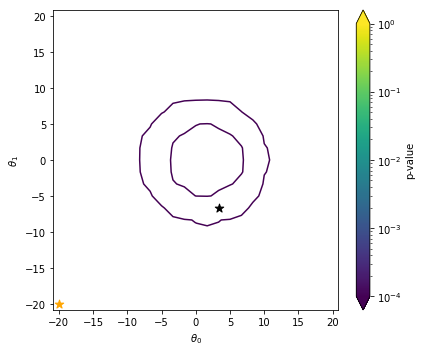

In [15]:
bin_size = (theta_max - theta_min)/(resolution - 1)
edges = np.linspace(theta_min - bin_size/2, theta_max + bin_size/2, resolution + 1)
centers = np.linspace(theta_min, theta_max, resolution)

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

cmin, cmax = 0.0001, 1.
    
pcm = ax.pcolormesh(
    edges, edges, p_values_expected.reshape((resolution, resolution)),
    norm=matplotlib.colors.LogNorm(vmin=cmin, vmax=cmax),
    cmap='viridis'
)
cbar = fig.colorbar(pcm, ax=ax, extend='both')
plt.contour(
    centers, centers, p_values_expected.reshape((resolution, resolution)),
    levels=[0.05],
    ls='-', color='orange'
)
plt.contour(
    centers, centers, p_values_observed.reshape((resolution, resolution)),
    levels=[0.05],
    ls='-', color='black'
)
plt.scatter(
    theta_grid[best_fit_expected][0], theta_grid[best_fit_expected][1],
    s=80., color='orange', marker='*'
)
plt.scatter(
    theta_grid[best_fit_observed][0], theta_grid[best_fit_observed][1],
    s=80., color='black', marker='*'
)

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label('p-value')

plt.tight_layout()
plt.show()


That's it for now. Please have a look at the documentation for a detailed description of all classes and functions. And if you're curious about SALLY, Fisher information matrices, and ensemble methods, please look at the second part of the tutorial!